<a href="https://colab.research.google.com/github/dl-course-adaptive-style-transfer/adaptive_style_transfer/blob/master/Adaptive_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ReadMe:

**Overview:**
This code trains a networks to make adaptive style transfer according to the paper "Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization" by Huang & Belongie.

Please select the parameters:

---


**Mode:**
train - trains the network from scratch
eval - evaluation mode - for a pre-trained model
resume_train - resume ongoing training

**Resume_train_from:**
Choose state to load for resume_train mode

**eval_mode_path:**
Choose state to load for evaluation mode

**style_dataset_name:**
Choose the dataset to be used for style images.

**content_dataset_name:**
Choose the dataset to be used for content images.

**optimizer:**
Choose the optimizer.

**lr_decay:**
Learning rate decay.

**Network:**
Choose the network to be used for style transfer.
Possible networks: VGG19, VGG16, VGG11, MobileNet, resnet


---


**Running the code:**

We shared with you our google drive folder where the datasets are located (They weight ~50GB so we can't place them in github):

Place project files under the following library:
/My drive/adaptive_style_transfer/

Then, before running, make sure to create the following (empty) libraries:

For VGG19: /My drive/adaptive_style_transfer/VGG19/models/images

For VGG16: /My drive/adaptive_style_transfer/VGG16/models/images

For VGG11: /My drive/adaptive_style_transfer/VGG11/models/images

For MobileNet V2: /My drive/adaptive_style_transfer/mobilenet/models/images

For ResNet: /My drive/adaptive_style_transfer/resnet/models/images

There's a cell called "Tensorboard" where you can see the results.
Log with samples (after each 1600 iterations) is available after the last cell.


# Arguments

In [0]:
# Train or Evaluate
_MODE = 'train' #@param ['train', 'eval', 'resume_train']
# Load models if resuming training or evaluating existing model
_resume_train_from = 'final_iter_1600.pth' #@param {type: "string"}
_eval_model_path = 'iter_179200.pth' #@param {type: "string"}
# Where dataset is located, its name
_dataset_backend = 'gdrive'  #@param ['gdrive']
_style_dataset_name = 'wikiart_1.zip' #@param ['wikiart_1.zip', 'wikiart_2.zip', 'wikiart_3.zip', 'wikiart_4.zip']
_content_dataset_name = 'train2014_coco_1.zip' #@param ['train2014_coco_1.zip', 'train2014_coco_2.zip', 'train2014_coco_3.zip', 'train2014_coco_4.zip']
# Optimizer settings
_optimizer = 'adam' #@param ['adam', 'SGD','RMSprop']
_lr_decay =  1e-5#@param {type:"number"}
_network = "ResNet50" #@param ["VGG19", "VGG16", "VGG11", "MobileNet", "ResNet50"]

# Implementation

In [0]:
!pip install piexif

import datetime, os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pdb

GLOBAL_ARGS = {}
GLOBAL_ARGS['dataset_backend'] = _dataset_backend
GLOBAL_ARGS['lr'] = 1e-4
GLOBAL_ARGS['lr_decay'] = _lr_decay
GLOBAL_ARGS['momentum'] = 0.9
GLOBAL_ARGS['optimizer'] = _optimizer
GLOBAL_ARGS['batch_size'] = 8
GLOBAL_ARGS['max_iters'] = 160000
GLOBAL_ARGS['max_iters_per_split'] = GLOBAL_ARGS['max_iters'] // 4
GLOBAL_ARGS['loss_style_w'] = 100 # resnet #10 #VGG16, VGG19, MobileNet # Weight of style loss
GLOBAL_ARGS['loss_content_w'] = 10 #resnet #1 #VGG16, VGG19, 10 MobileNet # Weight of content loss
GLOBAL_ARGS['MODE'] = _MODE
GLOBAL_ARGS['resume_train_from'] = _resume_train_from
GLOBAL_ARGS['eval_model_path'] = _eval_model_path
GLOBAL_ARGS['style_dataset_name'] = _style_dataset_name
GLOBAL_ARGS['content_dataset_name'] = _content_dataset_name
GLOBAL_ARGS['network'] = _network

"""
TAMIR:arguments from authors LUA code that are not used :
-- Training options
cmd:option('-resume', false, 'If true, resume training from the last checkpoint')
cmd:option('-weightDecay', 0, 'Weight decay')
cmd:option('-targetContentLayer', 'relu4_1', 'Target content layer used to compute the loss')
cmd:option('-targetStyleLayers', 'relu1_1,relu2_1,relu3_1,relu4_1', 'Target style layers used to compute the loss')
cmd:option('-tvWeight', 0, 'Weight of TV loss')
cmd:option('-reconStyle', false, 'If true, the decoder is also trained to reconstruct style images')
cmd:option('-normalize', false, 'If true, gradients at the loss function are normalized')
"""

# check mode is valid
assert GLOBAL_ARGS['MODE'] in ['train', 'eval', 'resume_train']
#### Mount Google Drive
from google.colab import drive
if GLOBAL_ARGS['dataset_backend'] == 'gdrive':
  drive.mount('/gdrive')
  if GLOBAL_ARGS['network'] == "VGG16":
    model_save_path = '/gdrive/My Drive/adaptive_style_transfer/VGG16/models/'
  elif GLOBAL_ARGS['network'] == "VGG19":
    model_save_path = '/gdrive/My Drive/adaptive_style_transfer/VGG19/models/'
  elif GLOBAL_ARGS['network'] == "VGG11":
    model_save_path = '/gdrive/My Drive/adaptive_style_transfer/VGG11/models/'
  elif GLOBAL_ARGS['network'] == "MobileNet":
    model_save_path = '/gdrive/My Drive/adaptive_style_transfer/mobilenet/models/'
  elif GLOBAL_ARGS['network'] == "ResNet50":
    model_save_path = '/gdrive/My Drive/adaptive_style_transfer/resnet/models/'

  #### Mount google cloud
from google.colab import auth
auth.authenticate_user()
project_id = 'sincere-muse-265918'
!gcloud config set project {project_id}

# For tensorboard use TF 2.x+
%tensorflow_version 2.x
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  cpu = torch.device("cpu")
else:
  # no GPU available
  assert 0

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Updated property [core/project].
TensorFlow 2.x selected.


# Dataset preparation - download or list, define dataloaders

In [0]:
import pdb
##### manual calculation of entire dataset length
## Number of content examples:
## 82783 /root/content_examples_paths.lst
## Number of style examples:
## 79433 /root/style_examples_paths.lst
##
## gbucket mode - images are stored on a GCP bucket (http access), we cant do 'ls' to get the file list
##                so I've manually creates a list by mounting the GCP bucket as a file-system and used 'gsutil ls'
##                The list is stored in the GCP bucket with the images
##                REMOVED !! as its slower than just copy zip file ...
## gdrive  mode - dataset is split to 4 parts in ZIP files, files are copied from gdrive and unzipped locally
##


# Function that takes a path to a dataset file, path to extract the dataset into
# copies it to local storage
# unzip
# removes the .zip archive from local storage
def copy_and_unzip_dataset(F, D):
      if os.path.isdir(D):
        print("found {} directory, skipping".format(D))
        return

      if os.path.isfile(F) == False:
        print("copying {}".format(F))
        !date
#        !cp "/gdrive/My Drive/adaptive_style_transfer/$DATASET_FILE" ./
        !rsync -m --progress "/gdrive/My Drive/adaptive_style_transfer/$DATASET_FILE" ./ # For use in case loading data from Google drive
        # !gsutil -m rsync "gs://adaptive_style_transfer_dl/$DATASET_FILE_NO_ROOT" ./ # For use in case loading data from Google Cloud bucket
        !date
      else:
        print("{} already exists locally".format(F))

      # unzipping
      print("unzipping {} to {}".format(F, D))
      !date
      !7z e ${DATASET_FILE} -o${DATASET_DIR}
      !date
      print("done unzipping, removing zip archive")
      !rm -fr ${DATASET_FILE}
# End


if GLOBAL_ARGS['MODE'] == 'eval':
  examples_path = '/gdrive/My Drive/adaptive_style_transfer/adain_paper_examples/'
  
  # Option 1 for eval - paper examples
  !rm -fr /root/*.lst
  # load style
  # !find '/gdrive/My Drive/adaptive_style_transfer/adain_paper_examples/style/' -name "*.jpg" -o -name "*.png" > /root/style_examples_paths.lst
  !find '/gdrive/My Drive/adaptive_style_transfer/adain_paper_examples/style/' -type f | sort > /root/style_examples_paths.lst
  !echo "$(wc -l /root/style_examples_paths.lst)"
  # load content
  !cat "/root/style_examples_paths.lst"
  # !find '/gdrive/My Drive/adain_paper_examples/content/' -name "*.jpg" -o -name "*.png" > /root/content_examples_paths.lst
  !find '/gdrive/My Drive/adaptive_style_transfer/adain_paper_examples/content/' -type f | sort > /root/content_examples_paths.lst
  !echo "$(wc -l /root/content_examples_paths.lst)"
  !cat "/root/content_examples_paths.lst"
  
  # Option 2 for eval
  # # Get COCO test
  # if (not os.path.isfile('./test2014.zip')) and (not os.path.isdir('./COCO_TEST')):
  #   !wget http://images.cocodataset.org/zips/test2014.zip
  # if not os.path.isdir('./COCO_TEST'):
  #   !7z e ./test2014.zip -o./COCO_TEST/
  # !rm -fr ./test2014.zip
  # !find ./COCO_TEST -name "*.jpg" > /root/content_examples_paths.lst
  # !echo "$(wc -l /root/content_examples_paths.lst)"
  # # Get Wikiart test
  # if (not os.path.isfile('./test.zip')) and (not os.path.isdir('./WIKIART_TEST')):
  #   !mkdir -p /root/.kaggle/
  #   !cp "/gdrive/My Drive/adaptive_style_transfer/kaggle.json" /root/.kaggle/
  #   !kaggle competitions download -c painter-by-numbers -f test.zip
  # if not os.path.isdir('./WIKIART_TEST'):
  #   !7z e test.zip -o./WIKIART_TEST/
  # !rm -fr test.zip
  # !find ./WIKIART_TEST -name "*.jpg" > /root/style_examples_paths.lst
  # !echo "$(wc -l /root/style_examples_paths.lst)"
else:
  if GLOBAL_ARGS['dataset_backend'] == 'gdrive':
    import os
    wikiart_file = './' + GLOBAL_ARGS['style_dataset_name']
    mscoco_file = './' + GLOBAL_ARGS['content_dataset_name']

    for FILE in [wikiart_file, mscoco_file]:
      # set dataset folder, content or style ?
      if 'wikiart' in FILE:
        D = './dataset_style'
        O = '/root/style_examples_paths.lst'
      elif 'coco' in FILE:
        D = './dataset_content'
        O = '/root/content_examples_paths.lst'
      # export env vars
      os.environ['DATASET_FILE'] = FILE
      os.environ['DATASET_FILE_NO_ROOT'] = FILE[2::]
      os.environ['DATASET_DIR'] = D
      os.environ['DATASET_LST'] = O
      # copy, extract and remove archive
      copy_and_unzip_dataset(FILE, D)
      # Now list the files
      !find ${DATASET_DIR} -name "*.jpg" > ${DATASET_LST}
      !echo "number of examples in this split:"
      !wc -l ${DATASET_LST}
  else:
    assert 0

found ./dataset_style directory, skipping
number of examples in this split:
19791 /root/style_examples_paths.lst
found ./dataset_content directory, skipping
number of examples in this split:
20695 /root/content_examples_paths.lst


In [0]:
from torch.utils import data
from PIL import Image, ImageFile
import requests
from io import BytesIO
from google.cloud import storage
import piexif

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000                                                                                              

class DatasetFolders(data.Dataset):
    def __init__(self, files_paths, transform):
        super(DatasetFolders, self).__init__()
        with open(files_paths) as F:
          paths = F.readlines()
        self.paths = [x.strip() for x in paths] 
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]

        if GLOBAL_ARGS['dataset_backend'] == 'gbucket':
          # GCS backend
          client = storage.Client(project=project_id)
          bucket = client.get_bucket('adaptive_style_transfer_dl')
          blob_path = path.split('adaptive_style_transfer_dl')[-1]
          blob_path = blob_path[1:] # first char is '/', trim it ...
          blob = bucket.get_blob(blob_path).download_as_string()
          bytes = BytesIO(blob)
          img = Image.open(bytes).convert('RGB')
        else:
          try:
            piexif.remove(path)
          except Exception:
            pass
          img = Image.open(path).convert('RGB')
        # End

        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'DatasetFolders'


if GLOBAL_ARGS['MODE'] == 'eval':
  # For testing, we don't want to resize to 512x512 and crop to 256
  # We want to work on FULL Resolution ! the network is fully convolutional so it should work
  test_trans = [
      transforms.Resize(size=(512, 512)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ]
  test_trans = transforms.Compose(test_trans)
  content_dataset = DatasetFolders('/root/content_examples_paths.lst', test_trans)
  style_dataset = DatasetFolders('/root/style_examples_paths.lst', test_trans)
else:
  trans = [
      transforms.Resize(size=(512, 512)),
      transforms.RandomCrop(256),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ]
  trans = transforms.Compose(trans)
  content_dataset = DatasetFolders('/root/content_examples_paths.lst', trans)
  style_dataset = DatasetFolders('/root/style_examples_paths.lst', trans)

# denorm (defined here to be close to the norm transformation)
def denorm(x):
    mu = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).to(device)
    sigma = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).to(device)
    return torch.clamp(x * sigma + mu, 0, 1)
# End

In [0]:
sd = 999
def torch_seed():
    global sd
    torch.manual_seed(sd)
    if torch.cuda.is_available():
      torch.cuda.manual_seed_all(sd)

## Training will not be in epochs but in iterations
## the dataloaders will need to be infinite
## (in epoch we finish an epoch at end of iteration)
## (doing as in the article/lua-torch code. training for 160,000 iteration with batch size of 8)

# the built in samplers in pytorch are not infinite, defining my own
def InfiniteSampler(dataset_len):
    torch_seed()
    perm_iter = iter(torch.randperm(dataset_len).tolist())
    while True:
      try:
        yield perm_iter.__next__()
      except StopIteration:
        perm_iter = iter(torch.randperm(dataset_len).tolist())
        yield perm_iter.__next__()

class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

def make_content_iter(batch_size=8, num_workers=8):
  return iter(data.DataLoader(
      content_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(content_dataset),
      num_workers=num_workers))
# End

def make_style_iter(batch_size=8, num_workers=8):
  return iter(data.DataLoader(
      style_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(style_dataset),
      num_workers=num_workers))

########################################
### Unit test
########################################
run = False
if run == True:
  content_iter = make_content_iter(1, 1)
  images = content_iter.next()
  print('images shape on batch size = {}'.format(images.size()))
  grid = torchvision.utils.make_grid(images)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  print(images[0])

# Network Implementation


![adain_net](https://i.imgur.com/jAyz9hY.jpg)

Implementing https://arxiv.org/pdf/1703.06868.pdf
There is an official reference in Torch / Lua @ https://github.com/xunhuang1995/AdaIN-style/



---


AdaIN Layer implements the following :

![adain_layer](https://i.imgur.com/OiqyfkN.png)



## VGG19

In [0]:
class vgg19_encoder(nn.Module):
      def __init__(self):
          super(vgg19_encoder, self).__init__()
          
          encoder = torchvision.models.vgg19(pretrained=True, progress=True)
          print(encoder) # print encoder, to make sure i'm extracting the correct layers
          encoder_layers = list(encoder.features.children())

          relu1_1 = 2
          relu2_1 = 7
          relu3_1 = 12
          relu4_1 = 21
          
          # style encoders - we need to extract intermediate features from SEVERAL layers
          # by splitting the model to parts we can take each part output AND feed it into next model part
          self.encoder_1 = nn.Sequential(*encoder_layers[:relu1_1])         # input -> relu1_1
          self.encoder_2 = nn.Sequential(*encoder_layers[relu1_1:relu2_1])  # relu1_1 -> relu2_1
          self.encoder_3 = nn.Sequential(*encoder_layers[relu2_1:relu3_1])  # relu2_1 -> relu3_1
          self.encoder_4 = nn.Sequential(*encoder_layers[relu3_1:relu4_1])  # relu3_1 -> relu4_1

          # Encoder IS NOT trainable - freeze it
          for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
              for p in e.parameters():
                  p.requires_grad = False
      # END of __init__()

      def forward(self, x, content = True):
        #
        #  ENC1 --- ENC2 --- ENC3 --- ENC4 ---
        #        |        |        |        |
        #     relu1_1    relu2_1  relu3_1  relu4_1

        # last_only : pass only the output of relu4_1 layer

        # init a list with X in it, X will be discarded later and is only used to init a list of tensors
        features = [ x ]

        features_1 = self.encoder_1(x)
        features_2 = self.encoder_2(features_1)
        features_3 = self.encoder_3(features_2)
        features_4 = self.encoder_4(features_3)
        
        if content is True:
          return features_4
        else:
          features.append(features_1)
          features.append(features_2)
          features.append(features_3)
          features.append(features_4)
          features = features[1:] # discards the X
          return features
      # END of forward()


vgg19_decoder = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, kernel_size=3, padding=0),
          )

## VGG16

In [0]:
""" 
  VGG16:
  References:
  https://arxiv.org/pdf/1603.08155.pdf
  https://harishnarayanan.org/writing/artistic-style-transfer/
"""
class vgg16_encoder(nn.Module):
      def __init__(self):
          super(vgg16_encoder, self).__init__()
          
          encoder = torchvision.models.vgg16(pretrained=True, progress=True)
          print(encoder) # print encoder, to make sure i'm extracting the correct layers
          encoder_layers = list(encoder.features.children())

          relu1_2 = 5
          relu2_2 = 9
          relu3_3 = 16
          relu4_3 = 23
          # relu5_1 = 28 # There's a possibility to use this layer as well to improve results
          
          # style encoders - we need to extract intermediate features from SEVERAL layers
          # by splitting the model to parts we can take each part output AND feed it into next model part
          self.encoder_1 = nn.Sequential(*encoder_layers[:relu1_2])         # input -> relu1_2
          self.encoder_2 = nn.Sequential(*encoder_layers[relu1_2:relu2_2])  # relu1_2 -> relu2_2
          self.encoder_3 = nn.Sequential(*encoder_layers[relu2_2:relu3_3])  # relu2_2 -> relu3_3
          self.encoder_4 = nn.Sequential(*encoder_layers[relu3_3:relu4_3])  # relu3_3 -> relu4_3
          # self.encoder_5 = nn.Sequential(*encoder_layers[relu4_3:relu5_1])  # relu4_3 -> relu5_1

          # Encoder IS NOT trainable - freeze it
          # for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4, self.encoder_5]:
          for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
              for p in e.parameters():
                  p.requires_grad = False
      # END of __init__()

      def forward(self, x, content = True):
        #
        #  ENC1 --- ENC2 --- ENC3 --- ENC4 ---
        #        |        |        |        |
        #     relu1_2    relu2_2  relu3_3  relu4_3

        # content : pass only the output of relu3_3 layer

        # init a list with X in it, X will be discarded later and is only used to init a list of tensors
        features = [ x ]

        features_1 = self.encoder_1(x)
        features_2 = self.encoder_2(features_1)
        features_3 = self.encoder_3(features_2)
        features_4 = self.encoder_4(features_3)
        # features_5 = self.encoder_5(features_4)
        
        if content is True:
          return features_3
        else:
          features.append(features_1)
          features.append(features_2)
          features.append(features_3)
          features.append(features_4)
          # features.append(features_5)
          features = features[1:] # discards the X
          return features
      # END of forward()


vgg16_decoder = nn.Sequential(
            # Unmark these layer when taking content from the last layer
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True),                          # ReLU(inplace=True)
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='nearest'),    # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True), # ReLU4_3
            # nn.ReflectionPad2d((1, 1, 1, 1)),
            # nn.Conv2d(512, 512, kernel_size=3, padding=0),  # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True), # ReLU4_2
            # nn.ReflectionPad2d((1, 1, 1, 1)),
            # nn.Conv2d(512, 512, kernel_size=3, padding=0),  # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True), # ReLU4_1
            # nn.ReflectionPad2d((1, 1, 1, 1)),
            # nn.Conv2d(512, 256, kernel_size=3, padding=0),  # Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # nn.ReLU(inplace=True), # relu3_3
            # nn.Upsample(scale_factor=2, mode='nearest'),    # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            # Decoder starts here if choosing relu3_3 for content extraction
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),  # Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            nn.ReLU(inplace=True), # relu3_2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),  # Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            nn.ReLU(inplace=True), # relu3_1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, kernel_size=3, padding=0),  # Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            nn.ReLU(inplace=True), # relu2_2
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),    # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            nn.Conv2d(128, 128, kernel_size=3, padding=0),  # Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            nn.ReLU(inplace=True), # relu2_1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, kernel_size=3, padding=0),   # Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
            nn.ReLU(inplace=True), # relu1_2
            nn.Upsample(scale_factor=2, mode='nearest'),    # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),    # Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            nn.ReLU(inplace=True),  # relu1_1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, kernel_size=3, padding=0),     # Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )

##VGG11

In [0]:
class vgg11_encoder(nn.Module):
      def __init__(self):
          super(vgg11_encoder, self).__init__()
          
          encoder = torchvision.models.vgg11(pretrained=True, progress=True)
          #print(encoder) # print encoder, to make sure i'm extracting the correct layers
          encoder_layers = list(encoder.features.children())
          block1_relu_1 = 2
          block2_relu_1 = 5
          block3_relu_1 = 8
          block4_relu_1 = 13

          self.encoder_1 = nn.Sequential(*encoder_layers[:block1_relu_1])
          self.encoder_2 = nn.Sequential(*encoder_layers[block1_relu_1:block2_relu_1])
          self.encoder_3 = nn.Sequential(*encoder_layers[block2_relu_1:block3_relu_1])
          self.encoder_4 = nn.Sequential(*encoder_layers[block3_relu_1:block4_relu_1])

          # Encoder IS NOT trainable - freeze it
          for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
              #print(e)
              for p in e.parameters():
                  p.requires_grad = False
      # END of __init__()

      def forward(self, x, content = False):
        features = [ x ]
        features_1 = self.encoder_1(x)
        features_2 = self.encoder_2(features_1)
        features_3 = self.encoder_3(features_2)
        features_4 = self.encoder_4(features_3)

        if content is True:
          return features_4

        features.append(features_1)
        features.append(features_2)
        features.append(features_3)
        features.append(features_4)
        features = features[1:] # discards the X
        return features
      # END of forward()


vgg11_decoder = nn.Sequential(
            # 2 conv block
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # 2 conv block
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # 1 conv block
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # 1 conv block
            # I'm modifying it and adding a RELU + CONV
            # because I want a none-linearity in this block as well
            # I'm trying 64->32->3 instaed of 64->64->3
            # which is accepted for vgg
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, kernel_size=3),
          )

##MobileNet V2

In [0]:
class mobilenet_encoder(nn.Module):
    def __init__(self):
        super(mobilenet_encoder, self).__init__()
          
        encoder = torchvision.models.mobilenet_v2(pretrained=True, progress=True)
        encoder_layers = list(encoder.features.children())

        # Manually remove BN layers
        del encoder_layers[0][1]         # BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[1].conv[0][1] # BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[1].conv[2]    # BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[2].conv[0][1] # BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[2].conv[1][1] # BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[2].conv[3]    # BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[3].conv[0][1] # BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[3].conv[1][1] # BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[3].conv[3]    # BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        del encoder_layers[4].conv[0][1]
        del encoder_layers[4].conv[1][1]
        del encoder_layers[4].conv[3]
        del encoder_layers[5].conv[0][1]
        del encoder_layers[5].conv[1][1]
        del encoder_layers[5].conv[3] #BN
        # del encoder_layers[5].conv[2]
        # del encoder_layers[6].conv[0][1]
        # del encoder_layers[6].conv[1][1]
        # del encoder_layers[6].conv[3]
        # # del encoder_layers[6].conv[2] # Remove last convolutional layers in order to get high dimension
        # del encoder_layers[6].conv[1] # Remove last convolutional layers in order to get high dimension
        # del encoder_layers[7].conv[0][1]
        # del encoder_layers[7].conv[1][1]
        # del encoder_layers[7].conv[3] # BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # del encoder_layers[7].conv[2] # Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

        InvertedResidual2 = 3
        InvertedResidual3 = 4
        InvertedResidual4 = 5
        InvertedResidual5 = 6
        
        # style encoders - we need to extract intermediate features from SEVERAL layers
        # by splitting the model to parts we can take each part output AND feed it into next model part
        self.encoder_1 = nn.Sequential(*encoder_layers[:InvertedResidual2])                   # input -> InvertedResidual2
        self.encoder_2 = nn.Sequential(*encoder_layers[InvertedResidual2:InvertedResidual3])  # InvertedResidual2 -> InvertedResidual3
        self.encoder_3 = nn.Sequential(*encoder_layers[InvertedResidual3:InvertedResidual4])  # InvertedResidual3 -> InvertedResidual4
        self.encoder_4 = nn.Sequential(*encoder_layers[InvertedResidual4:InvertedResidual5])  # InvertedResidual4 -> InvertedResidual5

        # Encoder IS NOT trainable - freeze it
        for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
#             print(e) # *****************************************************************
            for p in e.parameters():
                p.requires_grad = False

    # END of __init__()

    def forward(self, x, content = True):

            # init a list with X in it, X will be discarded later and is only used to init a list of tensors
            features = [ x ]

            features_1 = self.encoder_1(x)
            features_2 = self.encoder_2(features_1)
            features_3 = self.encoder_3(features_2)
            features_4 = self.encoder_4(features_3)
            # pdb.set_trace()     

            if content is True:
                # return features_4
                return features_2
            else:
                features.append(features_1)
                features.append(features_2)
                features.append(features_3)
                features.append(features_4)
                features = features[1:] # discards the X
                return features
    # END of forward()

class mobilenet_decoder(nn.Module):
    def __init__(self):
        super(mobilenet_decoder, self).__init__()
        
        self.relu6 = nn.ReLU6(inplace=True)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

        # self.conv0_1 = nn.Conv2d(32, 192, kernel_size=1, bias=False)  #(4)
        # self.conv0_2 = nn.Conv2d(192, 192, kernel_size=3, padding=0, groups=192, bias=False)
        # self.conv0_3 = nn.Conv2d(192, 32, kernel_size=1, bias=False)

        # self.conv1_1 = nn.Conv2d(32, 144, kernel_size=1, bias=False)  #(3)
        # self.conv1_2 = nn.Conv2d(144, 144, kernel_size=3, padding=0, groups=144, bias=False)
        # self.conv1_3 = nn.Conv2d(144, 24, kernel_size=1, bias=False)

        self.conv2_1 = nn.Conv2d(24, 144, kernel_size=1, bias=False) #(2)
        self.conv2_2 = nn.Conv2d(144, 144, kernel_size=3, padding=0, groups=144, bias=False)
        self.conv2_3 = nn.Conv2d(144, 24, kernel_size=1,bias=False)

        self.conv3_1 = nn.Conv2d(24, 96, kernel_size=1, bias=False) #(1)
        self.conv3_2 = nn.Conv2d(96, 96, kernel_size=3, padding=0, groups=96, bias=False)
        self.conv3_3 = nn.Conv2d(96, 16, kernel_size=1, bias=False)
        self.conv3_4 = nn.Conv2d(16, 32, kernel_size=1, bias=False)
        self.conv3_5 = nn.Conv2d(32, 32, kernel_size=3, padding=0, groups=32, bias=False)
        self.conv3_6 = nn.Conv2d(32, 32, kernel_size=3, padding=0, bias=False) #New layer to remove block artifacts
        self.conv3_7 = nn.Conv2d(32, 3, kernel_size=3, padding=0, bias=False) #(0)
    # END of __init__()

    def forward(self, x, encoder_outputs):
        out = x
        
        # InvertedResidual5
        # y = out
        # # y = torch.cat([out, encoder_outputs[3]], 1)
        # out = self.conv0_1(y)
        # out = self.relu6(out)
        # out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        # out = self.conv0_2(out)
        # out = self.relu6(out)
        # out = self.conv0_3(out)

        # InvertedResidual4
        # y = out
        # # y = torch.cat([out, encoder_outputs[2]], 1)
        # out = self.conv1_1(y)
        # out = self.relu6(out)
        # out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        # out = self.conv1_2(out)
        # out = self.up(out)
        # out = self.relu6(out)
        # out = self.conv1_3(out)
        
        # InvertedResidual3
        y = out
        # y = torch.cat([out, encoder_outputs[1]], 1)
        out = self.conv2_1(y)
        out = self.relu6(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv2_2(out)
        out = self.relu6(out)
        out = self.conv2_3(out)
        out = out + y # Residual

        # InvertedResidual2
        y = out
        # y = torch.cat([out, encoder_outputs[0]], 1)
        out = self.conv3_1(y)
        out = self.relu6(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv3_2(out)
        out = self.up(out)
        out = self.relu6(out)
        out = self.conv3_3(out)

        out = self.conv3_4(out)
        out = self.relu6(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv3_5(out)
        out = self.relu6(out)
        out = self.up(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')

        out = self.conv3_6(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv3_7(out)

        return out

##ResNet50

In [0]:
class resnet50_encoder(nn.Module):
      def __init__(self):
          super(resnet50_encoder, self).__init__()
          
          encoder = torchvision.models.resnet50(pretrained=True, progress=True)

          print(encoder) # print encoder, to make sure i'm extracting the correct layers
          encoder_layers = list(encoder.children())

          # Remove BN layers

          l = list(encoder_layers[:4])
          self.encoder_1 = nn.Sequential(*l)
          l = list(encoder_layers[4][0:1])
          self.encoder_2 = nn.Sequential(*l)
          l = list(encoder_layers[4][1:2])
          self.encoder_3 = nn.Sequential(*l)
          l = list(encoder_layers[4][2:3])
          self.encoder_4 = nn.Sequential(*l)

          # Encoder IS NOT trainable - freeze it
          for e in [self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4]:
              for p in e.parameters():
                  p.requires_grad = False
      # END of __init__()

      def forward(self, x, content = True):

        # init a list with X in it, X will be discarded later and is only used to init a list of tensors
        features = [ x ]

        features_1 = self.encoder_1(x)
        features_2 = self.encoder_2(features_1)
        features_3 = self.encoder_3(features_2)
        features_4 = self.encoder_4(features_3)        
        
        if content is True:
          return features_4
        else:
          features.append(features_1)
          features.append(features_2)
          features.append(features_3)
          features.append(features_4)
          features = features[1:] # discards the X
          return features
      # END of forward()

class resnet50_decoder(nn.Module):
    def __init__(self):
        super(resnet50_decoder, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv4_1 = nn.Conv2d(256, 64, kernel_size=1, bias=False)
        self.conv4_2 = nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False)
        self.conv4_3 = nn.Conv2d(64, 256, kernel_size=1, bias=False)
        
        self.conv3_1 = nn.Conv2d(256, 64, kernel_size=1, bias=False)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False)
        self.conv3_3 = nn.Conv2d(64, 256, kernel_size=1, bias=False)
        
        self.conv2_1 = nn.Conv2d(256, 64, kernel_size=1, bias=False)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False)
        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=1, bias=False)
        self.conv2_downsample = nn.Conv2d(256, 64, kernel_size=1, bias=False)

        self.conv1_1 = nn.Conv2d(64, 64, kernel_size=7, padding=0, bias=False) # New conv layer - not in encoder - to place after upsample
        self.conv1_2 = nn.Conv2d(64, 3, kernel_size=7, padding=0, bias=False)
    # END of __init__()

    def forward(self, x):
        out = x

        y = out             #(encoder_layer4)
        out = self.conv4_1(out)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv4_2(out)
        out = self.conv4_3(out)
        out = self.relu(out)

        y = out             #(encoder_layer3)
        out = self.conv3_1(y) 
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv3_2(out)
        out = self.conv3_3(out)
        out = self.relu(out)
        
        y = out             #(encoder_layer2)
        out = self.conv2_1(y)
        out = F.pad(out, (1, 1, 1, 1), mode='reflect')
        out = self.conv2_2(out)
        out = self.conv2_3(out)

        res = self.conv2_downsample(y)
        out = self.relu(out + res)

        y = out             #(encoder_layer1)
        out = self.up(y)
        out = F.pad(out, (3, 3, 3, 3), mode='reflect')
        out = self.conv1_1(out)
        out = self.up(out)
        out = self.conv1_2(out)

        return out

## Network

==== CONTENT ====
images shape on batch size = torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left image: content image after normalization.	 Right image: denormed content image


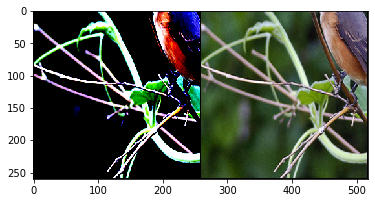

tensor([[[-1.2274, -1.2103, -1.0733,  ..., -1.7754, -1.6727, -1.6898],
         [-1.1932, -1.2617, -1.3302,  ..., -1.6727, -1.6727, -1.7412],
         [-1.2788, -1.1932, -1.2274,  ..., -1.6898, -1.6727, -1.7240],
         ...,
         [-1.5185, -1.5528, -1.5014,  ..., -1.5699, -1.4843, -1.5357],
         [-1.4672, -1.4158, -1.4158,  ..., -1.5014, -1.4329, -1.4329],
         [-1.5357, -1.3987, -1.3815,  ..., -1.4672, -1.3987, -1.4329]],

        [[-0.5651, -0.6352, -0.5301,  ..., -1.4580, -1.4055, -1.3004],
         [-0.5826, -0.6352, -0.6877,  ..., -1.2829, -1.3179, -1.2479],
         [-0.6527, -0.5651, -0.6001,  ..., -1.3179, -1.2829, -1.2654],
         ...,
         [-1.0903, -1.1604, -1.1078,  ..., -1.2304, -1.1604, -1.2129],
         [-1.0378, -1.0028, -0.9678,  ..., -1.1429, -1.1253, -1.1253],
         [-1.1078, -0.9503, -0.9153,  ..., -1.1078, -1.0728, -1.1078]],

        [[-0.7587, -0.9156, -0.8110,  ..., -1.2293, -1.1944, -1.1247],
         [-0.8458, -0.9330, -1.0376,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Left image: style image after normalization.	 Right image: denormed style image


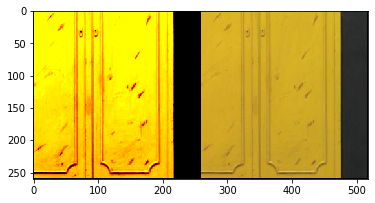

tensor([[[ 1.6495,  1.6495,  1.6495,  ..., -1.2617, -1.2274, -1.2274],
         [ 1.6495,  1.6495,  1.6495,  ..., -1.2788, -1.2445, -1.2445],
         [ 1.6495,  1.6667,  1.6495,  ..., -1.2788, -1.2445, -1.2617],
         ...,
         [ 1.2728,  1.2557,  1.2385,  ..., -1.3987, -1.4329, -1.4329],
         [ 1.3070,  1.3070,  1.2899,  ..., -1.4329, -1.4672, -1.4500],
         [ 1.3070,  1.3070,  1.3070,  ..., -1.4158, -1.4500, -1.4329]],

        [[ 1.0805,  1.0980,  1.0980,  ..., -1.1604, -1.1253, -1.1253],
         [ 1.0980,  1.0980,  1.0980,  ..., -1.1779, -1.1429, -1.1429],
         [ 1.0980,  1.1155,  1.0980,  ..., -1.1779, -1.1429, -1.1604],
         ...,
         [ 0.7479,  0.7479,  0.7654,  ..., -1.3004, -1.3354, -1.3354],
         [ 0.7829,  0.7829,  0.7829,  ..., -1.3354, -1.3704, -1.3529],
         [ 0.7654,  0.7654,  0.7829,  ..., -1.3179, -1.3529, -1.3354]],

        [[-1.1073, -1.1247, -1.1247,  ..., -0.9330, -0.8981, -0.8981],
         [-1.1421, -1.1421, -1.1247,  ..., -0

In [0]:
def get_mu_and_sigma(features):
    # input is a tensor of shape : [minibatch_size, channels, h ,w]
    # output is a tensor of shape : [minibatch_size, channels, 1 ,1]

    epsilon = 1e-6
    minibatch_size, channels = features.size()[:2]

    features_channels_stacked = features.reshape(minibatch_size, channels, -1)

    features_mean_per_channel = features_channels_stacked.mean(dim=2) # dim 0 : minibatch, dim 1 : channels, !! dim 2 : features col stack !!
    features_mean_per_channel = features_mean_per_channel.reshape(minibatch_size, channels, 1, 1) # set dim as tensor

    features_sigma_per_channel = features_channels_stacked.std(dim=2)
    features_sigma_per_channel = features_sigma_per_channel.reshape(minibatch_size, channels, 1, 1) # set dim as tensor
    # Notice! since we will do normalization (divide by sigma) - we add a small epsilon for numerical stablity (avoid NaN's or Inf's)
    return features_mean_per_channel, features_sigma_per_channel + epsilon

def deactivate_batchnorm(m):
  # Deactivates batch normalization layers
  if isinstance(m, nn.BatchNorm2d):
    m.reset_parameters()
    m.eval()
    with torch.no_grad():
      m.weight.fill_(1.0)
      m.bias.zero_()

class style_transfer_net(nn.Module):
      def __init__(self):
        super(style_transfer_net, self).__init__()

        ## using VGG as encoder/decoder
        ## TODO : consider using other architectures as suggested in the article
        ##        such as resnet34 etc. which are deep BUT have good convergence due to skip-connection (residuals)
        
        # encoder_t = 'VGG16' # TODO in the future this will be external argument

        if GLOBAL_ARGS['network'] == 'VGG16':
          self.encoder = vgg16_encoder()
        elif GLOBAL_ARGS['network'] == 'VGG11':
          self.encoder = vgg11_encoder()
        elif GLOBAL_ARGS['network'] == 'VGG19':
          self.encoder = vgg19_encoder()
        elif GLOBAL_ARGS['network'] == 'MobileNet':
          self.encoder = mobilenet_encoder()
        elif GLOBAL_ARGS['network'] == 'ResNet50':
          self.encoder = resnet50_encoder()

        # decoder_t = 'VGG16'
        if GLOBAL_ARGS['network'] == 'VGG16':
          self.decoder = vgg16_decoder
        elif GLOBAL_ARGS['network'] == 'VGG11':
          self.decoder = vgg11_decoder
        elif GLOBAL_ARGS['network'] == 'VGG19':
          self.decoder = vgg19_decoder
        elif GLOBAL_ARGS['network'] == 'MobileNet':
          self.decoder = mobilenet_decoder()
        elif GLOBAL_ARGS['network'] == 'ResNet50':
          self.decoder = resnet50_decoder()
      # End

      @staticmethod
      def adain_layer(content_features, style_features):
          # Adaptive instance normalization
          # Inputs are :
          #  content features - the content image output from VGG_ENCODER.relu4_1     [batch_size, 512, h/8, w/8]
          #  style features   - the style image output from VGG_ENCODER.relu4_1       [batch_size, 512, h/8, w/8]
          # Therefore they have the same dimensions of 512x(H/8)x(W/8)
          # This layer calculates a per-channel mean and std of the style features
          # and scales the content features so they have the same mean and std (per channel) of the style
          
          content_mu, content_sigma = get_mu_and_sigma(content_features)
          style_mu, style_sigma = get_mu_and_sigma(style_features)

          normalized_content_features = (content_features - content_mu) / content_sigma
          style_normalized_content_features = style_sigma*normalized_content_features + style_mu
          return style_normalized_content_features
      # End

      @staticmethod
      def calc_content_loss(out_content, adain_content):         
          return F.mse_loss(out_content, adain_content)

      # End

      @staticmethod
      def calc_style_loss(out_style, in_style):
          loss = 0
          for a,b in zip(out_style, in_style):
              a_mu, a_sigma = get_mu_and_sigma(a)
              b_mu, b_sigma = get_mu_and_sigma(b)
              loss += F.mse_loss(a_mu, b_mu) + F.mse_loss(a_sigma, b_sigma)
          return loss
      # End

      def forward(self, content, style, alpha=1.0):
        assert alpha >= 0
        assert alpha <= 1
        # TODO - add asserts that encoders are NOT trainable !!!

        ###########################################
        # Encoder pass of content and style images
        ###########################################
        style_features = self.encoder(style, content=False)   # for VGG19 [relu1_1, relu2_1, relu3_1, relu4_1]
        content_features = self.encoder(content, content=True)  # for VGG19 relu4_1

        ###########################################
        # AdaIn step
        ###########################################
        # feed into AdaIn layer the style & content features, get style-normalized content features
        if GLOBAL_ARGS['network'] == 'MobileNet':
          style4=style_features[1] # Layer 2
        elif GLOBAL_ARGS['network'] == 'VGG16':
          style4=style_features[2] # Layer 3
        else:
          style4=style_features[-1]  # Last layer
          
        style_norm_content = self.adain_layer(content_features, style4)
        style_norm_content = alpha*style_norm_content + (1-alpha)*content_features # hyper-parameter, a tradeoff between content and style

        ###########################################
        # Apply Style Transfer :
        # Enter the style-normalized-content features to the decoder
        # output is the transformed image
        ###########################################
        # pass through decoder, obtain transformed image
        if GLOBAL_ARGS['network'] == 'MobileNet':
            out = self.decoder(style_norm_content,style_features)
        else:
            out = self.decoder(style_norm_content)

        ###########################################
        # Loss calculation
        ###########################################
        # get content & style features of output image (after style transfer), same process as above
        # TODO - enclose this in a function, too much repeating code
        out_content_features = self.encoder(out, content=True)  # for VGG19 relu4_1
        # pdb.set_trace()
        content_loss = self.calc_content_loss(out_content_features, style_norm_content)
        # get style features
        out_style_features = self.encoder(out, content=False)   # for VGG19 [relu1_1, relu2_1, relu3_1, relu4_1]
        style_loss = self.calc_style_loss(out_style_features, style_features)
        
        return content_loss, style_loss
      # End

      def style_transfer(self, content, style, alpha=1.0):
        ###########################################
        # Encoder pass of content and style images
        ###########################################
        style_features = self.encoder(style, content=True)   # for VGG19 relu4_1
        content_features = self.encoder(content, content=True)  # for VGG19 relu4_1
        ###########################################
        # AdaIn step
        ###########################################
        style_norm_content = self.adain_layer(content_features, style_features)
        style_norm_content = alpha*style_norm_content + (1-alpha)*content_features
        if GLOBAL_ARGS['network'] == 'MobileNet': #or GLOBAL_ARGS['network'] == 'VGG16':
            style_features = self.encoder(style, content=False)
            return self.decoder(style_norm_content,style_features)
        else:
            return self.decoder(style_norm_content)
      # End

#########################
## Unit test
#########################
run=True
if run==True:
  ###############################
  ### Get images
  ###############################
  print("==== CONTENT ====")
  content_iter = make_content_iter(1, 1)
  content_images = content_iter.next()
  print('images shape on batch size = {}'.format(content_images.size()))
  denormed = denorm(content_images.to(device))
  print('Left image: content image after normalization.\t Right image: denormed content image') # URI
  grid = torchvision.utils.make_grid(torch.cat((content_images.to(cpu), denormed.to(cpu)), dim = 0))
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  print(content_images[0])
  print("==== STYLE ====")
  style_iter = make_style_iter(1, 1)
  style_images = style_iter.next()
  print('images shape on batch size = {}'.format(style_images.size()))
  print('Left image: style image after normalization.\t Right image: denormed style image') # URI
  denormed = denorm(style_images.to(device))
  grid = torchvision.utils.make_grid(torch.cat((style_images.to(cpu), denormed.to(cpu)), dim = 0))
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  print(style_images[0])
  ###############################
  ### Pass images through model
  ###############################
  model = style_transfer_net()
  if GLOBAL_ARGS['network'] == 'ResNet50':
    model.apply(deactivate_batchnorm)
  print(model)
  model.to(device)
  loss_c, loss_s = model(content_images.to(device), style_images.to(device))
  print("loss_c={}".format(loss_c))
  print("loss_s={}".format(loss_s))

"We train our network using **MS-COCO [36] as content
images** and a dataset of paintings mostly collected from
**WikiArt [39] as style images**, following the setting of [6].
Each dataset contains roughly 80; 000 training examples.
We use the adam optimizer [26] and a **batch size of 8**
content-style image pairs. During training, we **first resize
the smallest dimension of both images to 512 while preserving the aspect ratio, then randomly crop regions of size
256 × 256**. Since our network is fully convolutional, it can
be applied to images of any size during testing."

# LR scheduler

In [0]:
from torch.optim import Adam
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import lr_scheduler

def make_lr_sched(opt):
  return lr_scheduler.LambdaLR(opt, lambda iter_i: 1 / (1 + GLOBAL_ARGS['lr_decay'] * iter_i), last_epoch=-1)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
      return param_group['lr']
# End

# Tensorboard

In [0]:
# !kill 1737 # Kill the process using port 6006
%load_ext tensorboard

if GLOBAL_ARGS['MODE'] == 'train':
  !rm -fr logs
  # !rm -rf 'content/gdrive/My Drive/adaptive_style_transfer/models/logs'

elif GLOBAL_ARGS['MODE'] == 'resume_train':
  if GLOBAL_ARGS['network'] == "VGG16":
    !cp -r "/gdrive/My Drive/adaptive_style_transfer/VGG16/models/logs" "./"
  elif GLOBAL_ARGS['network'] == "VGG19":
    !cp -r "/gdrive/My Drive/adaptive_style_transfer/VGG19/models/logs" "./"
  elif GLOBAL_ARGS['network'] == "MobileNet":
    !cp -r "/gdrive/My Drive/adaptive_style_transfer/mobilenet/models/logs" "./"
  elif GLOBAL_ARGS['network'] == "ResNet50":
    !cp -r "/gdrive/My Drive/adaptive_style_transfer/resnet/models/logs" "./"

if GLOBAL_ARGS['MODE'] != 'eval':
  !mkdir -p logs/style
  !mkdir -p logs/content
  !mkdir -p logs/test_images/

%tensorboard --logdir logs

from torch.utils.tensorboard import SummaryWriter
writer_style = SummaryWriter(log_dir='logs/style/')
writer_content = SummaryWriter(log_dir='logs/content/')
writer_lr = SummaryWriter(log_dir='logs/lr/')
writer_test_images = SummaryWriter(log_dir='logs/test_images/')

Reusing TensorBoard on port 6006 (pid 1737), started 2:43:37 ago. (Use '!kill 1737' to kill it.)

<IPython.core.display.Javascript object>

# Style Transfer

In [0]:
def perform_style_transfer(model, content_images, style_images, display=False, i = 0):
  # move all to device
  for _x in [model, content_images, style_images]:
    _x.to(device)
  # set eval mode
  model.eval()
  if GLOBAL_ARGS['network'] == 'ResNet50':
    model.apply(deactivate_batchnorm)
  # freeze model gradients
  with torch.no_grad():
    out = model.style_transfer(content_images, style_images)
    out = denorm(out)
  if display:
    # display
    content_images = denorm(content_images)
    style_images = denorm(style_images)
    all_imgs = torch.cat((content_images, style_images, out), dim=0).to(cpu)
    grid = torchvision.utils.make_grid(all_imgs)
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)
    plt.show()

    grid = torchvision.utils.make_grid(all_imgs) # previous grid was changed with torch.transpose(...)
    if GLOBAL_ARGS['MODE'] != 'eval':
      writer_test_images.add_image('AdaSTN/test_images/', grid, i)
      writer_test_images.flush()
  return out, all_imgs
# END

# Train

In [0]:
from tqdm import tqdm
# from tqdm import tqdm_notebook
import time
from torchvision.utils import save_image

def train_iter(model, i, content_iter, style_iter, optimizer, lr_sched):
      model.to(device)
      model.train()
      if GLOBAL_ARGS['network'] == 'ResNet50':
        model.apply(deactivate_batchnorm)
      # pass images through network, get loss
      content_images = next(content_iter).to(device)
      style_images = next(style_iter).to(device)

      loss_c, loss_s = model(content_images, style_images)
      loss_c = GLOBAL_ARGS['loss_content_w'] * loss_c
      loss_s = GLOBAL_ARGS['loss_style_w'] * loss_s
      loss = loss_c + loss_s
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # LR scheduler
      lr_sched.step()
      # loss metrics
      writer_style.add_scalar('AdaSTN/loss', loss_s, i)
      writer_content.add_scalar('AdaSTN/loss', loss_c, i)
      writer_lr.add_scalar('AdaSTN/LR', get_lr(optimizer), i)
      writer_style.flush()
      writer_content.flush()
      writer_lr.flush()
      # Checkpoint
      if (i % 1600 == 0):
        # save checkpoint
        model_save_name = '{}/iter_{}.pth'.format(model_save_path, i)
        tqdm.write("saving model checkpoint: {}".format(model_save_name))
        torch.save({
              'iter': i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'lr_scheduler_state_dict': lr_sched.state_dict(),
              }, model_save_name)
        # print images once in a while
        tqdm.write("printing train images results: (content, style, out)")
        _ , grid = perform_style_transfer(model, content_images, style_images, display=True, i = i)
        img_save_name = '{}/images/iter_{}.png'.format(model_save_path, i)
        save_image(grid, img_save_name)
        
        if GLOBAL_ARGS['network'] == "VGG16":
          !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/VGG16/models/"
        elif GLOBAL_ARGS['network'] == "VGG19":
          !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/VGG19/models/"
        elif GLOBAL_ARGS['network'] == "MobileNet":
          !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/mobilenet/models/"
        elif GLOBAL_ARGS['network'] == "ResNet50":
          !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/resnet/models/"

# checkpoint : if None, start model train from scratch
#              if not None, load existing state
def train(model, checkpoint=None):
  # create iters
  content_iter = make_content_iter(batch_size=GLOBAL_ARGS['batch_size'])
  style_iter = make_style_iter(batch_size=GLOBAL_ARGS['batch_size'])
  # load model dict (before declaring optimizer)
  # I think i need to do it before optimizer because when we declare optimizer
  # we pass the model parameters
  if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])

  # create optimizer
  if GLOBAL_ARGS['optimizer'] == 'adam':
    optimizer = Adam(model.parameters(), lr=GLOBAL_ARGS['lr'])
  elif GLOBAL_ARGS['optimizer'] == 'SGD':
    optimizer = SGD(model.parameters(), lr=GLOBAL_ARGS['lr'], momentum=GLOBAL_ARGS['momentum'])
  else:
    optimizer = RMSprop(model.parameters(), lr=GLOBAL_ARGS['lr'], momentum=GLOBAL_ARGS['momentum'])

  # make LR scheduler
  lr_sched = make_lr_sched(optimizer)

  START_ITER = 0
  if checkpoint:
    # when loading optimiezr, needs to move it's stored tensors to gpu device
    # a bit ugly - but there is no optimizer.to(device) code ... 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
      for k, v in state.items():
          if isinstance(v, torch.Tensor):
              state[k] = v.to(device)

    lr_sched.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    START_ITER = checkpoint['iter'] + 1
    assert (START_ITER > 0)

  # because ive split the datasets in 4 - I'm dividing the loop counter by 4
  # if training entire dataset all at once - dont divide by 4 ...
  ITERS = range(START_ITER, START_ITER + GLOBAL_ARGS['max_iters_per_split'])
  for i in tqdm(ITERS, initial=START_ITER):
  # for i in tqdm_notebook(ITERS, initial=START_ITER):
    train_iter(model, i, content_iter, style_iter, optimizer, lr_sched)
  # End of for
  model_save_name = '{}/final_iter_{}.pth'.format(model_save_path, i)
  print("saving model checkpoint: {}".format(model_save_name))
  torch.save({
      'iter': i,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'lr_scheduler_state_dict': lr_sched.state_dict(),
      }, model_save_name)
  if GLOBAL_ARGS['network'] == "VGG16":
    !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/VGG16/models/"
  elif GLOBAL_ARGS['network'] == "VGG19":
    !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/VGG19/models/"
  elif GLOBAL_ARGS['network'] == "MobileNet":
    !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/mobilenet/models/"
  elif GLOBAL_ARGS['network'] == "ResNet":
    !cp -r "./logs" "/gdrive/My Drive/adaptive_style_transfer/resnet/models/"
# End

# Model eval

In [0]:
import os
from random import randint

def model_eval(model, iteration=0): 
  model.eval()
  if GLOBAL_ARGS['network'] == 'ResNet50':
    model.apply(deactivate_batchnorm)
  
  if False == True:
  # define iters
   content_iter = make_content_iter(batch_size=GLOBAL_ARGS['batch_size'])
   style_iter = make_style_iter(batch_size=GLOBAL_ARGS['batch_size'])
   # get images
   content_images = next(content_iter).to(device)
   style_images = next(style_iter).to(device)
  else:
    content_images = content_dataset[0].unsqueeze(dim=0)
    style_images = style_dataset[0].unsqueeze(dim=0)
    for i in range(1, len(content_dataset)):
      content_images=torch.cat([content_images, content_dataset[i].unsqueeze(dim=0)], dim=0)
      style_images=torch.cat([style_images, style_dataset[i].unsqueeze(dim=0)], dim=0)
    content_images = content_images.to(device)
    style_images = style_images.to(device)
  # perform style transfer
  _ , out = perform_style_transfer(model, content_images, style_images, display=True)
  img_save_name = '{}/images/eval.png'.format(model_save_path, iteration)
  save_image(out, img_save_name, nrow=len(content_dataset))
  
# def model_eval(model): 
#   model.eval()
#   # create network instance
#   model = style_transfer_net()
    # if GLOBAL_ARGS['network'] == 'ResNet50':
      # model.apply(deactivate_batchnorm)
#   # define iters
#   content_iter = make_content_iter(batch_size=GLOBAL_ARGS['batch_size'])
#   style_iter = make_style_iter(batch_size=GLOBAL_ARGS['batch_size'])
#   # get images
#   content_images = next(content_iter).to(device)
#   style_images = next(style_iter).to(device)
#   # perform style transfer
#   perform_style_transfer(model, content_images, style_images, display=True)

# train / eval / resume wrapper

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

  0%|          | 0/40000 [00:02<?, ?it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_0.pth
printing train images results: (content, style, out)


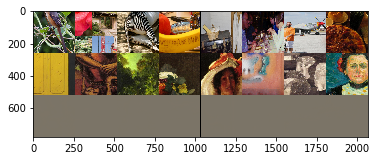

  4%|▍         | 1600/40000 [11:41<4:40:25,  2.28it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_1600.pth
printing train images results: (content, style, out)


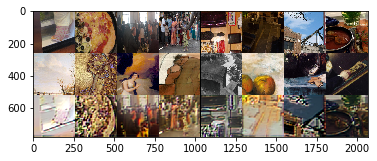

  8%|▊         | 3200/40000 [23:13<3:08:03,  3.26it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_3200.pth
printing train images results: (content, style, out)


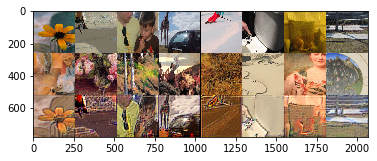

 12%|█▏        | 4800/40000 [34:34<5:25:59,  1.80it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_4800.pth


 12%|█▏        | 4800/40000 [34:35<5:25:59,  1.80it/s]

printing train images results: (content, style, out)


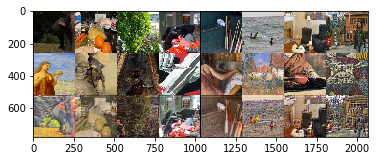

 16%|█▌        | 6400/40000 [46:15<2:44:11,  3.41it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_6400.pth
printing train images results: (content, style, out)


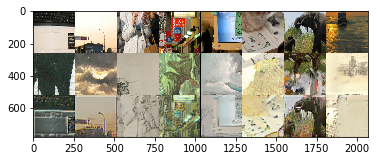

 20%|██        | 8000/40000 [57:30<2:52:01,  3.10it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_8000.pth
printing train images results: (content, style, out)


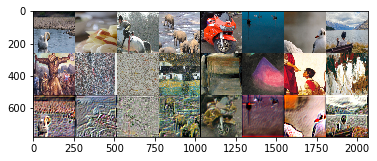

 24%|██▍       | 9600/40000 [1:09:47<4:21:14,  1.94it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_9600.pth
printing train images results: (content, style, out)


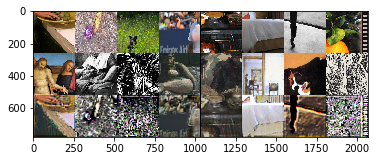

 28%|██▊       | 11200/40000 [1:21:37<2:44:40,  2.91it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_11200.pth
printing train images results: (content, style, out)


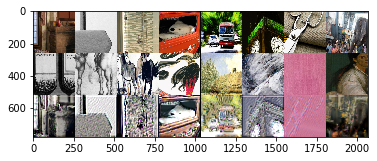

 32%|███▏      | 12800/40000 [1:32:56<2:25:59,  3.11it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_12800.pth


 32%|███▏      | 12800/40000 [1:32:57<2:25:59,  3.11it/s]

printing train images results: (content, style, out)


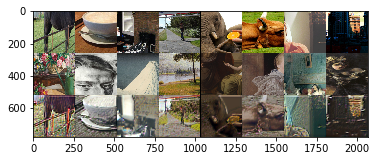

 36%|███▌      | 14400/40000 [1:44:25<2:24:16,  2.96it/s]

saving model checkpoint: /gdrive/My Drive/adaptive_style_transfer/resnet/models//iter_14400.pth


 36%|███▌      | 14400/40000 [1:44:26<2:24:16,  2.96it/s]

printing train images results: (content, style, out)


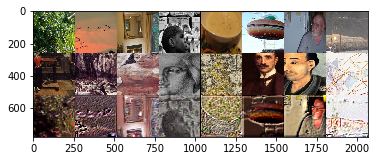

 37%|███▋      | 14747/40000 [1:47:39<3:26:00,  2.04it/s]

In [0]:
# create network instance
model = style_transfer_net()
if GLOBAL_ARGS['network'] == 'ResNet50':
    model.apply(deactivate_batchnorm)

if GLOBAL_ARGS['MODE'] == 'train':  
  # train model
  train(model)
elif GLOBAL_ARGS['MODE'] == 'resume_train':
  # resume training
  saved_checkpoint_path=model_save_path + GLOBAL_ARGS['resume_train_from']
  print("loading model from {}".format(saved_checkpoint_path))
  checkpoint = torch.load(saved_checkpoint_path)
  train(model, checkpoint)
elif GLOBAL_ARGS['MODE'] == 'eval':
  saved_checkpoint_path=model_save_path + GLOBAL_ARGS['eval_model_path']
  checkpoint = torch.load(saved_checkpoint_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  model_eval(model)
else:
  assert 0